# Insight Challenge for Fun (7/7/17)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import Imputer, scale, normalize
from sklearn.model_selection import LeaveOneOut 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics

/anaconda/envs/env3_wip/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data from CSV

In [2]:
data_df = pd.read_csv('breast-cancer-wisconsin.data.txt', sep=",", header=None, dtype=str)
data_df.columns = ['id','clump_thickness','uniformity_size','uniformity_shape','marginal_adhesion','epi_cell_size',
                   'bare_nuclei','bland_chromatin','normal_nucleoli','mitosis','class']
data_df = data_df.set_index(['id'])
data_df.head()

,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
id,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
clump_thickness      699 non-null object
uniformity_size      699 non-null object
uniformity_shape     699 non-null object
marginal_adhesion    699 non-null object
epi_cell_size        699 non-null object
bare_nuclei          699 non-null object
bland_chromatin      699 non-null object
normal_nucleoli      699 non-null object
mitosis              699 non-null object
class                699 non-null object
dtypes: object(10)
memory usage: 60.1+ KB


# Exploration
Although all of these "numbers" are categorical variables, I'm electing to think of them as numbers so I can look at things like correlation

In [4]:
numeric_col = ['clump_thickness','uniformity_size','uniformity_shape','marginal_adhesion','epi_cell_size',
                   'bare_nuclei','bland_chromatin','normal_nucleoli','mitosis']
data_df[numeric_col] = data_df[numeric_col].apply(pd.to_numeric, errors='coerce')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
clump_thickness      699 non-null int64
uniformity_size      699 non-null int64
uniformity_shape     699 non-null int64
marginal_adhesion    699 non-null int64
epi_cell_size        699 non-null int64
bare_nuclei          683 non-null float64
bland_chromatin      699 non-null int64
normal_nucleoli      699 non-null int64
mitosis              699 non-null int64
class                699 non-null object
dtypes: float64(1), int64(8), object(1)
memory usage: 60.1+ KB


So there is some missing and Na data. Need to impute with mean or median. Let's see the descriptive stats

In [5]:
data_df.describe()

,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Okay, so impute missing data with median since we know that mean isn't in the middle of the population

### Impute

In [6]:
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
temp = pd.DataFrame(imp.fit_transform(data_df))
temp.columns = data_df.columns
temp.index = data_df.index
data_df = temp
del temp # to free up memory

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
clump_thickness      699 non-null float64
uniformity_size      699 non-null float64
uniformity_shape     699 non-null float64
marginal_adhesion    699 non-null float64
epi_cell_size        699 non-null float64
bare_nuclei          699 non-null float64
bland_chromatin      699 non-null float64
normal_nucleoli      699 non-null float64
mitosis              699 non-null float64
class                699 non-null float64
dtypes: float64(10)
memory usage: 60.1+ KB


Nothing is missing or NA now

### Check for correlation of features

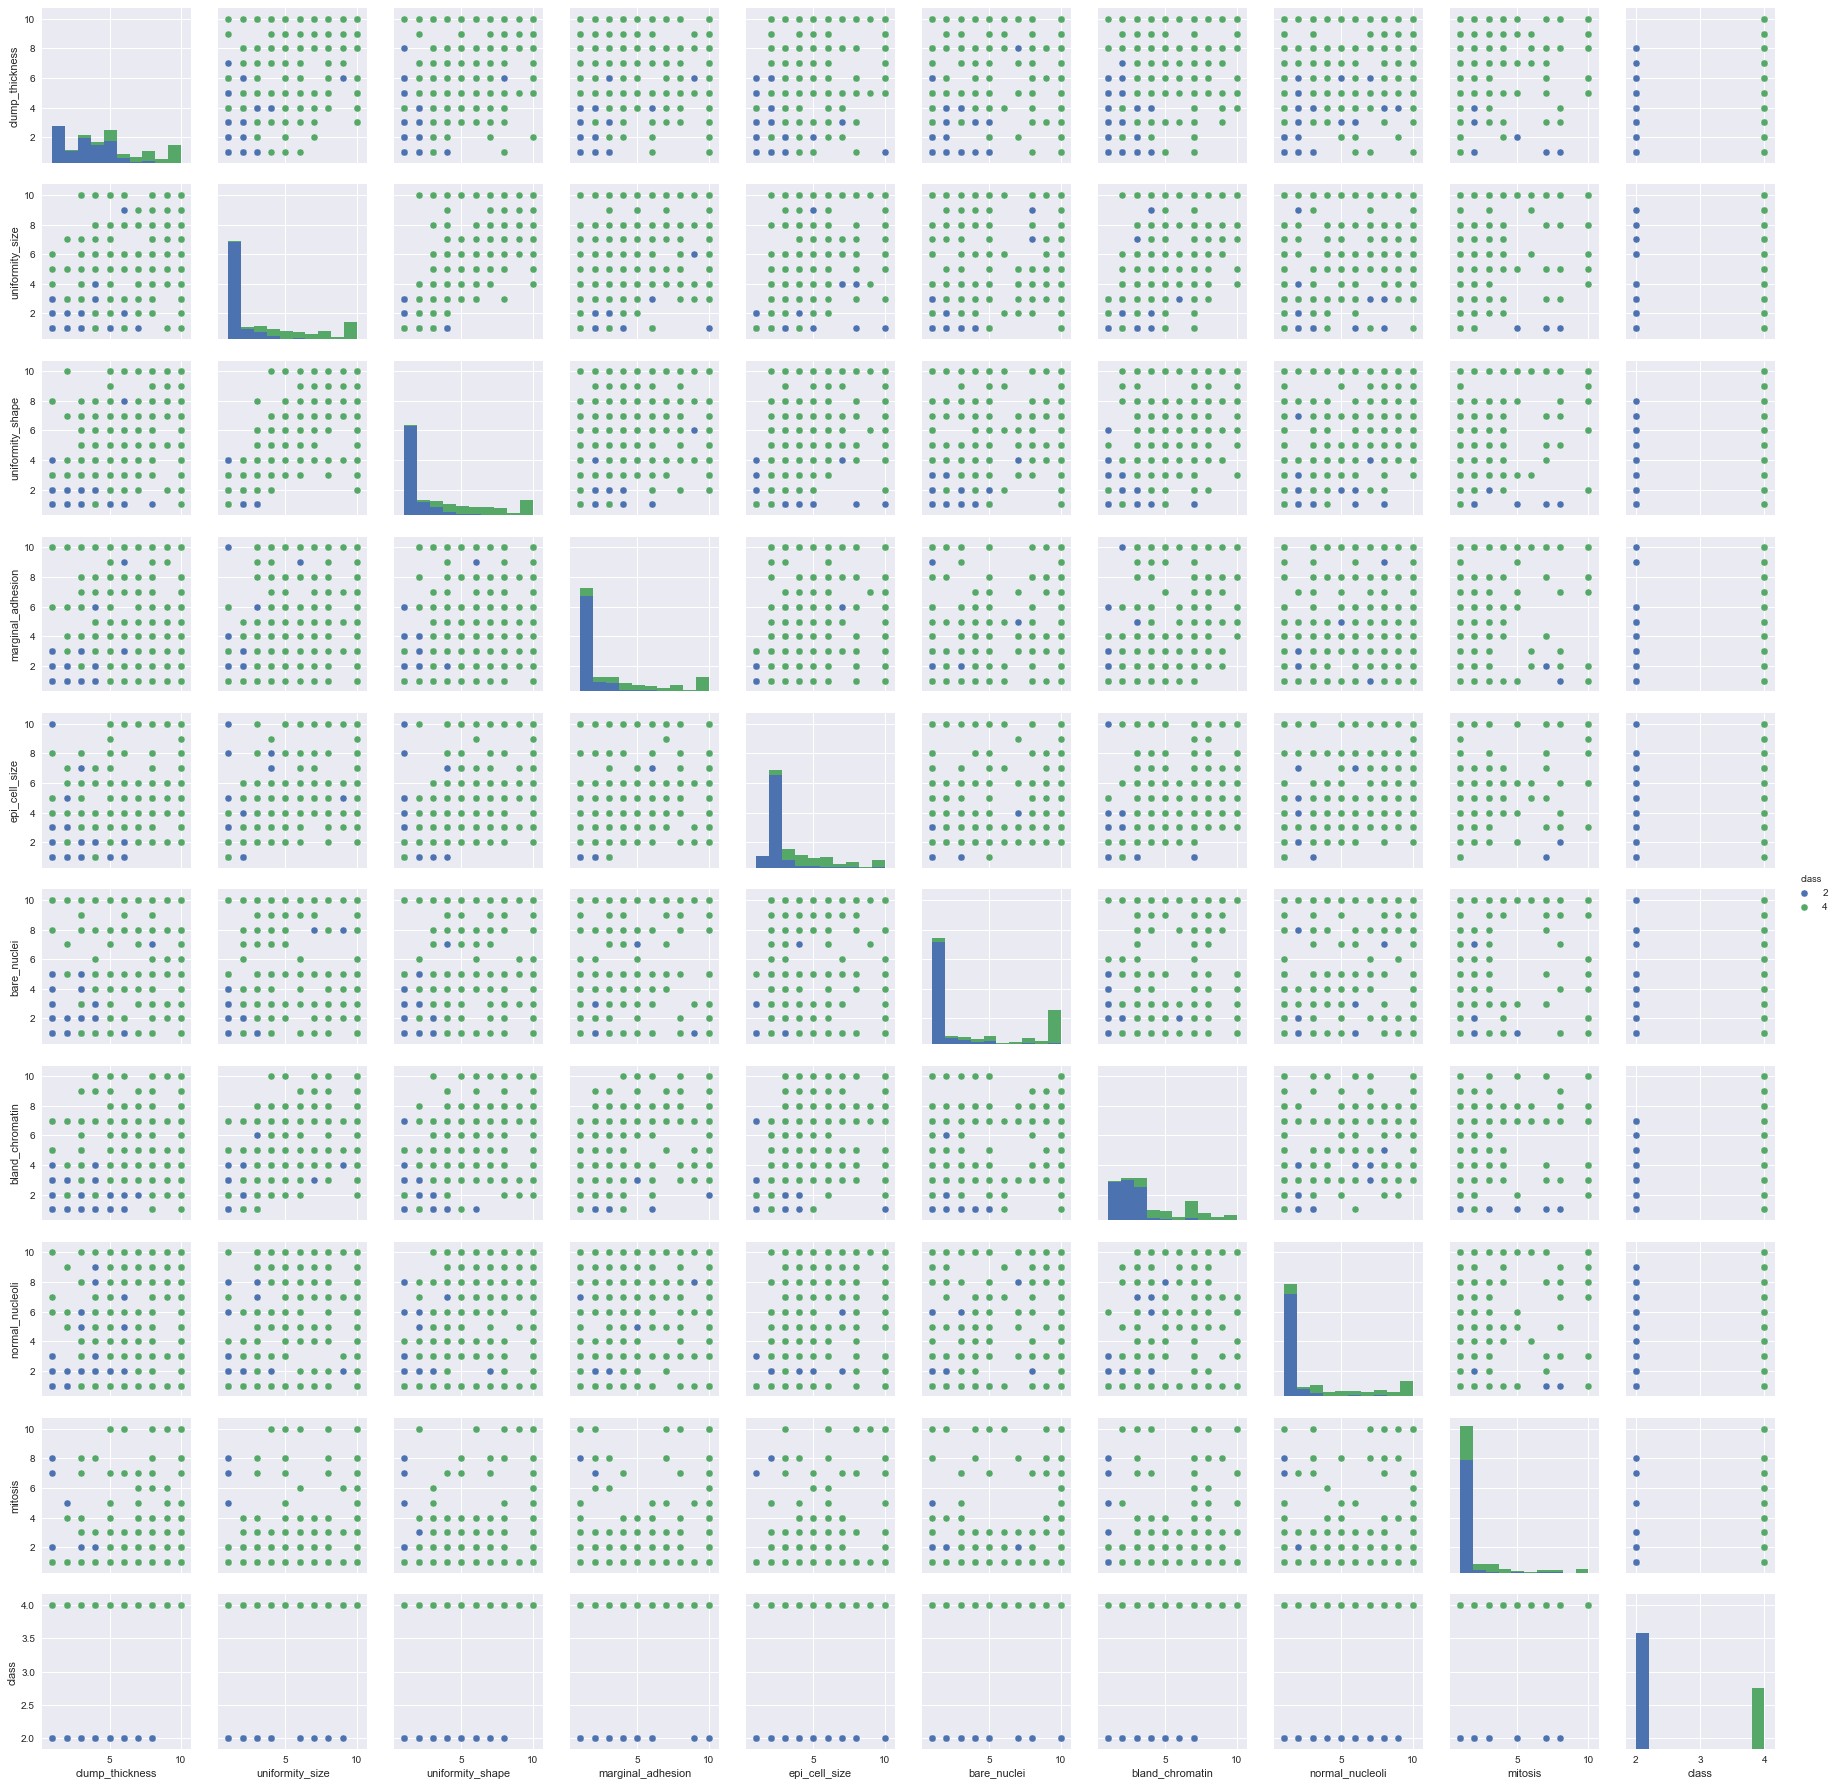

In [8]:
sns.pairplot(data_df, hue='class', hue_order=[2,4])

Nothing obviously correlates so that's fine

### Check for similarity

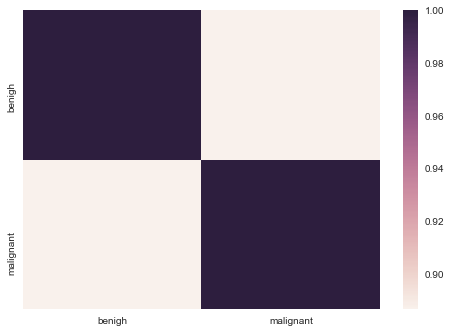

In [9]:
for_heatmap_median = cosine_similarity(data_df.groupby('class').median().values)
good_xtick_labels = ['benigh','malignant']
good_ytick_labels = good_xtick_labels
this_plot = sns.heatmap(for_heatmap_median, xticklabels=good_xtick_labels, yticklabels=good_ytick_labels)

Looks like the 2 groups are pretty different so this should make for a straight forward prediction
# Binomial Classification

## Treat data as numerics
Everything here is a categorical data, not numeric. But dummifying everything will just expand the columns unnecessarily. So I'm treating them as numerics. This should be fine when the classifier is fitting the model. But it is important to NOT report "usual" descriptive statistics with the data since that's not meaningful.

### Normalize

In [10]:
temp = pd.DataFrame(normalize(data_df[numeric_col]))
temp.columns = numeric_col
temp.index = data_df.index
data_df[numeric_col] = temp[numeric_col]
del temp # to free up memory

### Cross Validation
Decided to do Leave One Out cross validation because small data set. Otherwise would do k-fold

In [11]:
X = data_df[data_df.columns[:-1]].values
y = (data_df['class'].values == 4)
features_labels = data_df.columns
features_labels = features_labels.drop(['class'])

loo = LeaveOneOut()
loo.get_n_splits(X)

for train_index, test_index in loo.split(X):
    #print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print(X_train, X_test, y_train, y_test)

In [12]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy', random_state=1)
model = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, features_labels[indices[f]], importances[indices[f]]))

  1) bare_nuclei                    0.228849
  2) mitosis                        0.228801
  3) uniformity_size                0.120846
  4) normal_nucleoli                0.096672
  5) epi_cell_size                  0.091304
  6) uniformity_shape               0.087172
  7) marginal_adhesion              0.062720
  8) clump_thickness                0.045535
  9) bland_chromatin                0.038102


In [13]:
scores = cross_val_score(model, data_df, y, cv=5)
print('Cross-validated scores:', scores)
print('')

predictions = cross_val_predict(model, data_df, y, cv=5)
accuracy = metrics.accuracy_score(y, predictions)
precision = metrics.precision_score(y, predictions)
recall = metrics.recall_score(y, predictions)
roc_auc = metrics.roc_auc_score(y, predictions)

print('Cross-Predicted Accuracy:', accuracy)
print('Cross-Predicted Precision:', precision)
print('Cross-Predicted Sensitivity (aka recall):', recall)
print('Cross-Predicted AUC of ROC:', roc_auc)

Cross-validated scores: [ 1.  1.  1.  1.  1.]

Cross-Predicted Accuracy: 1.0
Cross-Predicted Precision: 1.0
Cross-Predicted Sensitivity (aka recall): 1.0
Cross-Predicted AUC of ROC: 1.0


# In conclusion, I got this!

- I did not optimize number of trees because the data set is small so I just did 100. 

- I did not use SMOTE because the data was not severely imbalanced

There is 35 min left so I could look at these 2 things...or I'm gonna try this again treating things as categorical values. Gonna go with the latter since using 100 trees is still fast so I don't care to optimize number of trees as much.

## Treat data as categorical

### Re-import data and clean again

In [14]:
data_df2 = pd.read_csv('breast-cancer-wisconsin.data.txt', sep=",", header=None, dtype=str)
data_df2.columns = ['id','clump_thickness','uniformity_size','uniformity_shape','marginal_adhesion','epi_cell_size',
                   'bare_nuclei','bland_chromatin','normal_nucleoli','mitosis','class']
data_df2 = data_df2.set_index(['id'])
data_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
clump_thickness      699 non-null object
uniformity_size      699 non-null object
uniformity_shape     699 non-null object
marginal_adhesion    699 non-null object
epi_cell_size        699 non-null object
bare_nuclei          699 non-null object
bland_chromatin      699 non-null object
normal_nucleoli      699 non-null object
mitosis              699 non-null object
class                699 non-null object
dtypes: object(10)
memory usage: 60.1+ KB


No need to impute since no missing data/NA

### Dummify

In [15]:
dummy_clump_thickness = pd.get_dummies(data_df2['clump_thickness'], prefix='clump')
dummy_uniformity_size = pd.get_dummies(data_df2['uniformity_size'], prefix='u_size')
dummy_uniformity_shape = pd.get_dummies(data_df2['uniformity_shape'], prefix='u_shape')
dummy_marginal_adhesion = pd.get_dummies(data_df2['marginal_adhesion'], prefix='adhesion')
dummy_epi_cell_size = pd.get_dummies(data_df2['epi_cell_size'], prefix='epi_size')
dummy_bare_nuclei = pd.get_dummies(data_df2['bare_nuclei'], prefix='bare_nuc')
dummy_bland_chromatin = pd.get_dummies(data_df2['bland_chromatin'], prefix='bland_chro')
dummy_normal_nucleoli = pd.get_dummies(data_df2['normal_nucleoli'], prefix='norm_nucleoli')
dummy_mitosis = pd.get_dummies(data_df2['mitosis'], prefix='mitosis')
#dummy_col = ['dummy_clump_thickness','dummy_uniformity_size','dummy_uniformity_shape','dummy_marginal_adhesion',
             #'dummy_epi_cell_size','dummy_bare_nuclei','dummy_bland_chromatin','dummy_normal_nucleoli','dummy_mitosis']

In [16]:
data_df2 = data_df2.join([dummy_clump_thickness,dummy_uniformity_size,dummy_uniformity_shape,dummy_marginal_adhesion,
             dummy_epi_cell_size,dummy_bare_nuclei,dummy_bland_chromatin,dummy_normal_nucleoli,dummy_mitosis])
data_df2.drop(numeric_col, axis=1, inplace=True)
data_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70335481 entries, 1000025 to 95719
Data columns (total 91 columns):
class               object
clump_1             uint8
clump_10            uint8
clump_2             uint8
clump_3             uint8
clump_4             uint8
clump_5             uint8
clump_6             uint8
clump_7             uint8
clump_8             uint8
clump_9             uint8
u_size_1            uint8
u_size_10           uint8
u_size_2            uint8
u_size_3            uint8
u_size_4            uint8
u_size_5            uint8
u_size_6            uint8
u_size_7            uint8
u_size_8            uint8
u_size_9            uint8
u_shape_1           uint8
u_shape_10          uint8
u_shape_2           uint8
u_shape_3           uint8
u_shape_4           uint8
u_shape_5           uint8
u_shape_6           uint8
u_shape_7           uint8
u_shape_8           uint8
u_shape_9           uint8
adhesion_1          uint8
adhesion_10         uint8
adhesion_2          uint8
ad

### Cross Validation
All parameters are left to be the same as when treating data as numerics

In [17]:
X2 = data_df2[data_df2.columns[1:]].values
y2 = (data_df2['class'].values == 4)
features_labels2 = data_df2.columns
features_labels2 = features_labels2.drop(['class'])

#loo = LeaveOneOut()
#loo.get_n_splits(X)

for train_index, test_index in loo.split(X):
    #print('TRAIN:', train_index, 'TEST:', test_index)
    X_train2, X_test2 = X2[train_index], X2[test_index]
    y_train2, y_test2 = y2[train_index], y2[test_index]
    #print(X_train, X_test, y_train, y_test)
    
#clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy', random_state=1)
model = clf.fit(X_train2, y_train2)
predictions2 = clf.predict(X_test2)

importances2 = clf.feature_importances_
indices2 = np.argsort(importances2)[::-1]

for f in range(X_train2.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, features_labels2[indices2[f]], importances2[indices2[f]]))

  1) mitosis_8                      0.000000
  2) u_shape_2                      0.000000
  3) u_shape_4                      0.000000
  4) u_shape_5                      0.000000
  5) u_shape_6                      0.000000
  6) u_shape_7                      0.000000
  7) u_shape_8                      0.000000
  8) u_shape_9                      0.000000
  9) adhesion_1                     0.000000
 10) adhesion_10                    0.000000
 11) adhesion_2                     0.000000
 12) adhesion_3                     0.000000
 13) adhesion_4                     0.000000
 14) adhesion_5                     0.000000
 15) adhesion_6                     0.000000
 16) adhesion_7                     0.000000
 17) adhesion_8                     0.000000
 18) adhesion_9                     0.000000
 19) epi_size_1                     0.000000
 20) epi_size_10                    0.000000
 21) epi_size_2                     0.000000
 22) u_shape_3                      0.000000
 23) u_sha

In [ ]:
scores2 = cross_val_score(model, data_df2, y2, cv=5)
print('Cross-validated scores:', scores2)
print('')

predictions = cross_val_predict(model, data_df2, y2, cv=5)
accuracy2 = metrics.accuracy_score(y2, predictions2)
precision2 = metrics.precision_score(y2, predictions2)
recall2 = metrics.recall_score(y2, predictions2)
roc_auc2 = metrics.roc_auc_score(y2, predictions2)

print('Cross-Predicted Accuracy:', accuracy2)
print('Cross-Predicted Precision:', precision2)
print('Cross-Predicted Sensitivity (aka recall):', recall2)
print('Cross-Predicted AUC of ROC:', roc_auc2)

This crashed whenever I ran it...